In [ ]:
import sys
sys.path.append('..')
import edlib
import numpy as np
from collections import Counter, defaultdict
import operator
from string import ascii_uppercase


from lrd_parser import LRD_Report
from utils.bio import hamming_distance, identity_shift, OverlapAlignment, compress_homopolymer
import networkx as nx

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2

%load_ext autoreload
%autoreload 2

In [ ]:
lrd_report_fn = '/Poppy/abzikadze/centroFlye/centroFlye_repo/experiments/20191023/lrd_d6z1_rel3_Karen/decomposition.tsv'
monomers_fn = "/Poppy/abzikadze/tandem_flye/data/human/isolated_centromeres/extracted_HORs/CEN6/monomers/inferred_monomers_single.fa"

lrd_report = LRD_Report(lrd_report_fn=lrd_report_fn, monomers_fn=monomers_fn)

In [74]:
monomer_strings = {r_id: record.string for r_id, record in lrd_report.records.items()}
len(monomer_strings)

471

In [75]:
def filter_strings(monomer_strings, max_gap=0.05):
    filtered_strings = {}
    for r_id, string in monomer_strings.items():
        ngaps = Counter(string)['=']
        if ngaps / len(string) <= max_gap:
            filtered_strings[r_id] = string
    return filtered_strings

In [76]:
monomer_strings = filter_strings(monomer_strings)
len(monomer_strings)

408

In [12]:
def get_frequent_kmers(monomer_strings, k, min_mult=10):
    all_kmers = Counter()
    read_kmer_locations = defaultdict(list)
    for r_id, string in monomer_strings.items():
        for i in range(len(string)-k+1):
            kmer = string[i:i+k]
            if '=' not in kmer:
                all_kmers[kmer] += 1
                read_kmer_locations[kmer].append((r_id, i))
                
    frequent_kmers = {kmer: cnt for kmer, cnt in all_kmers.items()
                      if cnt >= min_mult}
    frequent_kmers_read_pos = {kmer: read_kmer_locations[kmer] for kmer in frequent_kmers}
    return frequent_kmers, frequent_kmers_read_pos


In [59]:
class DeBruijnGraph:
    def __init__(self, k):
        self.graph = nx.DiGraph()
        self.k = k

    def add_kmer(self, kmer, coverage=1):
        self.graph.add_edge(kmer[:-1], kmer[1:],
                            edge_kmer=kmer,
                            coverages=[coverage])

    def add_kmers(self, kmers, coverage=None):
        for kmer in kmers:
            if coverage is None:
                self.add_kmer(kmer)
            else:
                self.add_kmer(kmer, coverage=coverage[kmer])
                
    def collapse_nonbranching_paths(self):
        def node_on_nonbranching_path(graph, node):
            return nx.number_of_nodes(graph) > 1 \
                and graph.in_degree(node) == 1 \
                and graph.out_degree(node) == 1

        for node in list(self.graph.nodes()):
            if node_on_nonbranching_path(self.graph, node):
                in_edge = list(self.graph.in_edges(node))[0]
                out_edge = list(self.graph.out_edges(node))[0]
                # in_edge_color = self.graph.edges[in_edge]['color']
                # out_edge_color = self.graph.edges[out_edge]['color']
                in_edge_kmer = self.graph.edges[in_edge]['edge_kmer']
                out_edge_kmer = self.graph.edges[out_edge]['edge_kmer']
                in_edge_cov = self.graph.edges[in_edge]['coverages']
                out_edge_cov = self.graph.edges[out_edge]['coverages']

                in_node = in_edge[0]
                out_node = out_edge[1]

                new_kmer = in_edge_kmer + \
                    out_edge_kmer[-(len(out_edge_kmer)-self.k+1):]
                new_coverages = in_edge_cov + out_edge_cov
                new_coverages.sort()
                self.graph.add_edge(in_node, out_node,
                                    edge_kmer=new_kmer,
                                    # color=in_edge_color,
                                    coverages=new_coverages,
                                    length=self.k+len(new_coverages)-1)
                self.graph.remove_node(node)

    def get_contigs(self):
        self.collapse_nonbranching_paths()
        contigs, coverages = [], []
        for edge in self.graph.edges():
            contigs.append(self.graph.get_edge_data(*edge)['edge_kmer'])
            coverages.append(np.median(self.graph.get_edge_data(*edge)['coverages']))
        return contigs, coverages

In [113]:
def iterative_graph(monomer_strings, min_k=250, max_k=250, min_mult=10, step=10):
    dbs, all_contigs = {}, {}
    for k in range(min_k, max_k+1, step):
        print(f'k={k}')
        # print(len(input_strings))
        input_strings = monomer_strings.copy()
        frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(input_strings, k=k, min_mult=min_mult)
        db = DeBruijnGraph(k=k)
        db.add_kmers(frequent_kmers, coverage=frequent_kmers)
        contigs, coverages = db.get_contigs()
        # lens = sorted(len(contig) for contig, coverage in zip(contigs, coverages))[::-1]
        lens = sorted((len(contig), coverage) for contig, coverage in zip(contigs, coverages))[::-1]
        long_edges = [x for x in lens if x[1] >= 50]
        print(f'lengths of contigs: {lens}')
        print(f'# long edges = {long_edges}')
        for i in range(len(contigs)):
            for j in range(min_mult):
                input_strings[f'contig_k{k}_i{i}_j{j}'] = contigs[i]
        print("")
        all_contigs[k] = contigs
        dbs[k] = db
    return all_contigs, dbs

In [114]:
contigs, dbs = iterative_graph(monomer_strings)

k=250
lengths of contigs: [(991, 13.0), (824, 12.0), (798, 15.0), (700, 12.0), (626, 11.0), (594, 14.0), (549, 14.0), (540, 12.0), (531, 15.0), (531, 13.0), (512, 12.0), (510, 24.0), (496, 12.0), (479, 12.0), (469, 11.0), (447, 12.0), (429, 11.0), (414, 13.0), (408, 11.0), (405, 10.0), (397, 11.0), (360, 15.0), (350, 10.0), (345, 12.0), (345, 12.0), (330, 19.0), (327, 19.0), (321, 37.5), (321, 26.5), (321, 23.0), (316, 11.0), (312, 50.0), (312, 17.0), (312, 10.0), (311, 12.0), (311, 10.0), (309, 13.0), (300, 25.0), (297, 24.0), (291, 10.0), (285, 26.0), (284, 10.0), (282, 78.0), (282, 52.0), (282, 34.0), (282, 32.0), (282, 22.0), (282, 19.0), (282, 11.0), (279, 11.0), (276, 33.0), (276, 11.0), (275, 10.0), (273, 35.0), (273, 10.0), (267, 72.0), (267, 10.0), (266, 11.0), (266, 10.0), (265, 10.0), (264, 1142.0), (264, 102.0), (262, 75.0), (261, 37.0), (259, 10.0), (259, 10.0), (258, 37.0), (257, 10.0), (256, 10.0), (256, 10.0), (255, 24.5), (255, 11.0), (255, 10.0), (252, 1158.0), (252, 

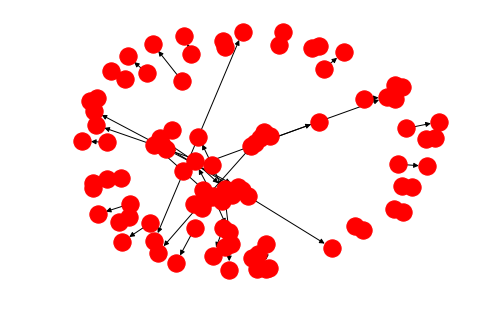

In [115]:
nx.draw(dbs[250].graph)

In [116]:
nice_cx_debr_graph = ndex2.create_nice_cx_from_networkx(dbs[250].graph)

nice_cx_debr_graph.upload_to(server='public.ndexbio.org', username = 'seryrzu',
                             password = 'Kxoq)V?Z]vrgt87x*XO,:we)U&RwEEG!')

Generating CX


'http://public.ndexbio.org/v2/network/338ee119-fce6-11e9-bb65-0ac135e8bacf'